In [436]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from iminuit import Minuit
from scipy import stats
from tqdm import tqdm
from numba import prange
import sys
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [32]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.figsize'] = (8, 4)
np.random.seed(50340488)

C:\Users\rizfn\AppData\Local\Temp\ipykernel_22612\4067300880.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# q1

In [27]:
stats.norm.cdf(65, 50, 20) - stats.norm.cdf(55, 50, 20)

0.17466632194020804

In [33]:
data = pd.DataFrame(np.random.normal(50, 20, 120))
data.mean(), data.std() / np.sqrt(120)

(0    49.368831
 dtype: float64,
 0    1.911499
 dtype: float64)

In [223]:
## MIGHT BE WRONG?

(stats.norm.sf(60, 50, 20)**2)/0.6

0.15865902133848309

# q2

In [34]:
df = pd.DataFrame({'g':[5.50, 5.61, 4.88, 5.07, 5.26], 'err':[0.10, 0.21, 0.15, 0.14, 0.13]})
df

,g,err
0,5.50,0.10
1,5.61,0.21
2,4.88,0.15
3,5.07,0.14
4,5.26,0.13


In [44]:
def weighted_mean(y, y_err):
    numerator = 0
    denominator = 0
    for gval, errval in zip(y, y_err):
        numerator += gval / errval**2
        denominator += 1 / errval**2
    mean = numerator / denominator
    err = np.sqrt(1 / denominator)
    return mean, err

weighted_mean(df['g'], df['err'])

(5.279305828390056, 0.06005034708204228)

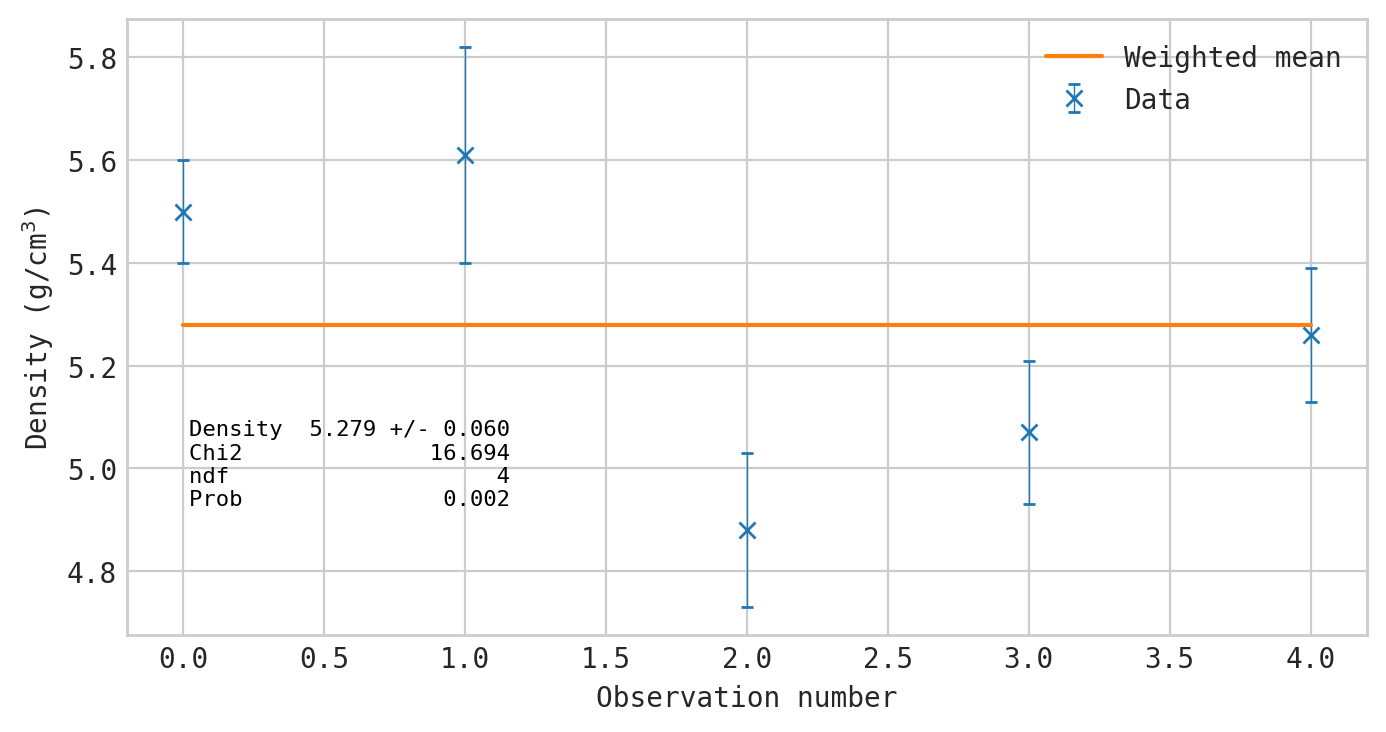

In [60]:
# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(lambda x,c: c, df.index, df['g'], df['err'])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, c=np.average(df['g']))     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 1                   # Number of variables (a, b, c, d)
Ndof_fit = len(df) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.errorbar(df.index, df['g'], df['err'], label='Data', capsize=2, elinewidth=0.5, fmt='x ')
x = np.linspace(min(df.index), max(df.index), 100)
plt.plot(x, minuit.values['c']*x**0, label=f'Weighted mean')
plt.xlabel('Observation number')
plt.ylabel(r'Density (g/cm$^3$)')
plt.legend()

d = {
     'Density': [minuit.values['c'], minuit.errors['c']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.35, text, ax, fontsize=8)


# q3

## 3.1

In [449]:
n_sims = 25

N = 1_000_000
delta_t = 130

n_waiting = np.zeros(n_sims)

for i in prange(n_sims):
    arrival_times = np.random.normal(0, 120, N)
    departure_times = np.random.normal(delta_t, 50, N)
    ship_same_day = (departure_times > arrival_times)
    n_waiting[i] = (N - np.sum(ship_same_day))/N

n_waiting.mean(), n_waiting.std()

(0.1586402, 0.000307661632317065)

Text(0, 0.5, 'Waiting time (s)')

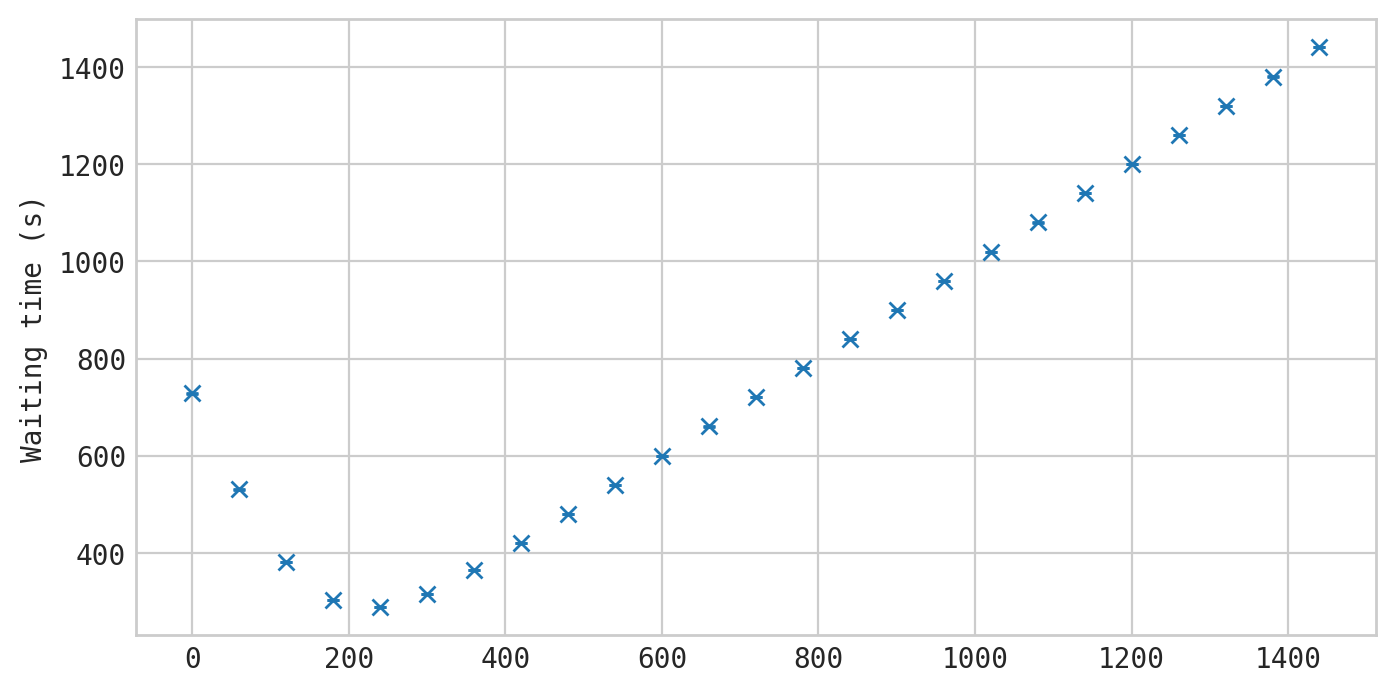

In [461]:
delta_t_list = np.linspace(0, 24*60, n_sims)
waiting_time_list = np.zeros(n_sims)
waiting_time_err_list = np.zeros(n_sims)

for i in prange(n_sims):
    arrival_times = np.random.normal(0, 120, N)
    departure_times = np.random.normal(delta_t_list[i], 50, N)
    time_difference = departure_times - arrival_times
    waiting_idx = (time_difference < 0)
    time_difference[waiting_idx] = 1440 + departure_times[np.roll(waiting_idx, -1)] - arrival_times[waiting_idx]
    waiting_time_list[i] = np.mean(time_difference)
    waiting_time_err_list[i] = np.std(time_difference)

plt.errorbar(delta_t_list, waiting_time_list, waiting_time_err_list/np.sqrt(N), label='Waiting times', capsize=2, elinewidth=0.5, fmt='x ')
plt.ylabel('Waiting time (s)')

Text(0, 0.5, 'Waiting time (s)')

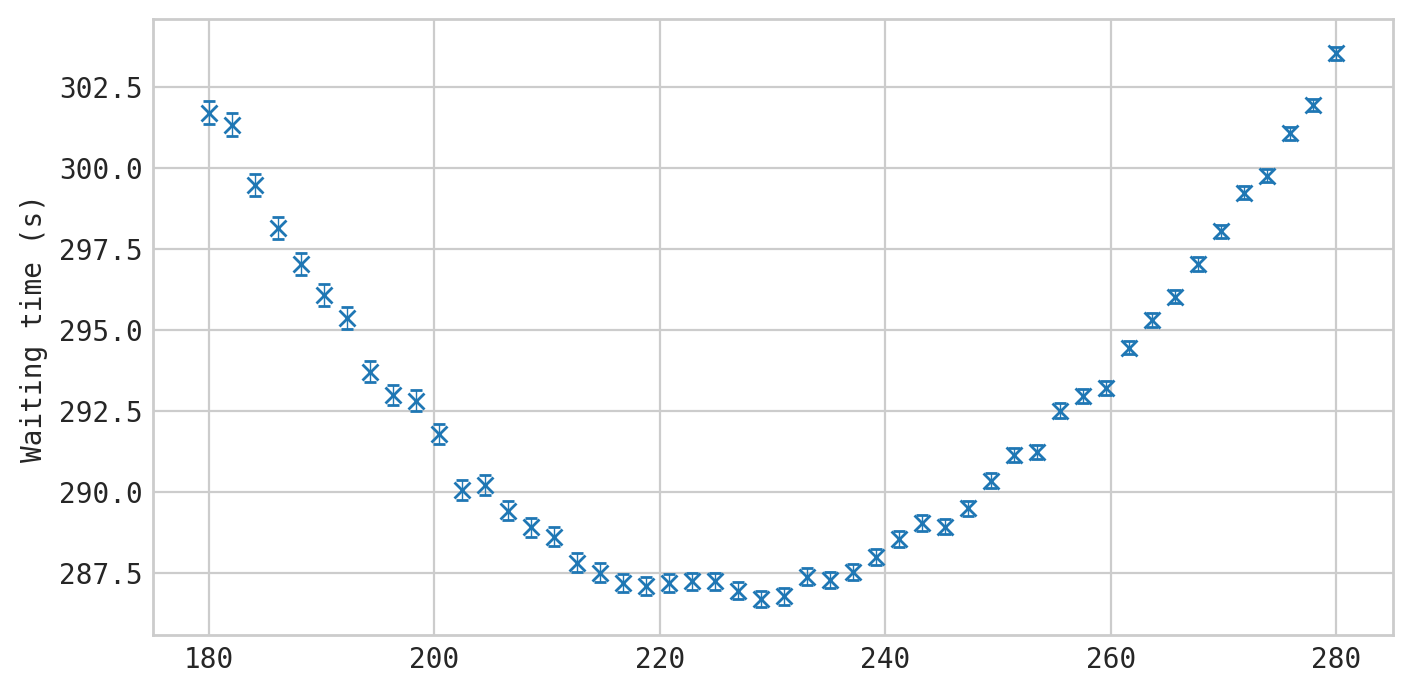

In [480]:
n_sims = 50

delta_t_list = np.linspace(180, 280, n_sims)
waiting_time_list = np.zeros(n_sims)
waiting_time_err_list = np.zeros(n_sims)

for i in prange(n_sims):
    arrival_times = np.random.normal(0, 120, N)
    departure_times = np.random.normal(delta_t_list[i], 50, N)
    time_difference = departure_times - arrival_times
    waiting_idx = (time_difference < 0)
    time_difference[waiting_idx] = 1440 + departure_times[np.roll(waiting_idx, -1)] - arrival_times[waiting_idx]
    waiting_time_list[i] = np.mean(time_difference)
    waiting_time_err_list[i] = np.std(time_difference)

plt.errorbar(delta_t_list, waiting_time_list, waiting_time_err_list/np.sqrt(N), label='Waiting times', capsize=2, elinewidth=0.5, fmt='x ')
plt.ylabel('Waiting time (s)')

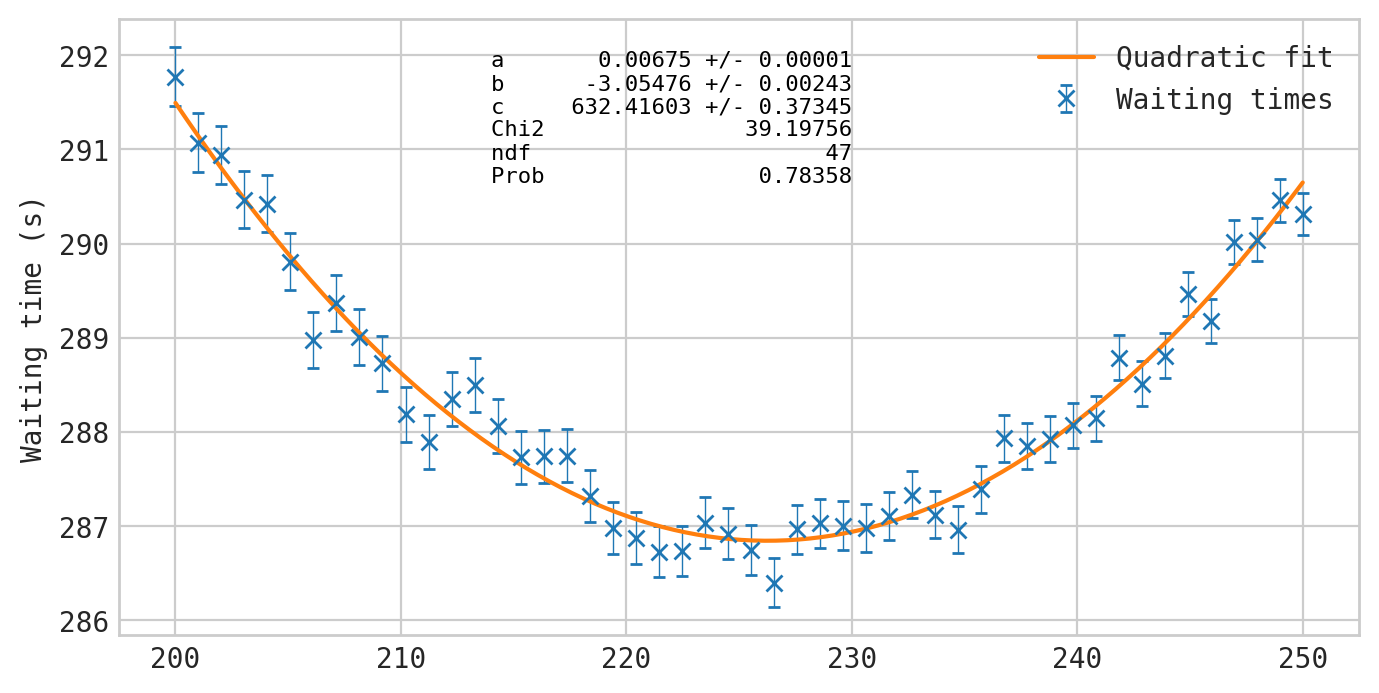

In [488]:
n_sims = 50

delta_t_list = np.linspace(200, 250, n_sims)
waiting_time_list = np.zeros(n_sims)
waiting_time_err_list = np.zeros(n_sims)

for i in prange(n_sims):
    arrival_times = np.random.normal(0, 120, N)
    departure_times = np.random.normal(delta_t_list[i], 50, N)
    time_difference = departure_times - arrival_times
    waiting_idx = (time_difference < 0)
    time_difference[waiting_idx] = 1440 + departure_times[np.roll(waiting_idx, -1)] - arrival_times[waiting_idx]
    waiting_time_list[i] = np.mean(time_difference)
    waiting_time_err_list[i] = np.std(time_difference)


def quadfit(x, a, b, c):
    return a*(x**2) + b*x + c

chi2_object = Chi2Regression(quadfit, delta_t_list, waiting_time_list, waiting_time_err_list/np.sqrt(N))
chi2_object.errordef = 1.0

minuit = Minuit(chi2_object, a=0.005, b=-3, c=500)

minuit.migrad()

Nvar = 3                                        # Number of variables (a, b, c)
Ndof_fit = len(delta_t_list) - Nvar

Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()

plt.errorbar(delta_t_list, waiting_time_list, waiting_time_err_list/np.sqrt(N), label='Waiting times', capsize=2, elinewidth=0.5, fmt='x ')
plt.ylabel('Waiting time (s)')
domain = np.linspace(200, 250, 200)
plt.plot(domain, quadfit(domain, minuit.values['a'], minuit.values['b'], minuit.values['c']), label=f'Quadratic fit')
plt.legend()

d = {'a': [minuit.values['a'], minuit.errors['a']],
     'b': [minuit.values['b'], minuit.errors['b']],
     'c': [minuit.values['c'], minuit.errors['c']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.3, 0.95, text, ax, fontsize=8)

## 3.2

In [65]:
def safe_root(f, df, a, b, tolerance=1e-13, max_iterations=1000):
    '''
    Uses a root finding algorithm that guarantees convergence every time step.

    The function attempts a newton stop every iteration, and if the approximate root
    lies outside the interval, it uses a bisection step again. The interval is
    constricted at the end of every step. 

    Args: 
        f (function): A function with a single (float) input
        df (function): The derivative of the function, again with a single (float) input
        a (float): The lower end of the initial interval. Used as the initial Newton seed
        b (float): The upper end of the interval. Note that f(a)*f(b) should be negative
        tolerance (float): The tolerance at which the algorithm stops iterating
        max_iterations (int): The maximum iterations after which the algorithm ends

    Returns:
        x (float): The approximate root of the function, correct to `tolerance`
        n_calls (int): The number of function calls used by the algorithm
    '''
    f_a = f(a)
    x = a
    f_x = f_a
    n_calls = 1
    for i in range(max_iterations):
        newton_x = x - (f_x / df(x))  # attempt newton step
        n_calls += 1
        if (a < newton_x < b):
            x = newton_x
        else:
            x = a + (b-a) / 2  # bisection step
        f_x = f(x)
        n_calls += 1
        if f_a * f_x > 0:
            a, f_a = x, f_x
        else:
            b = x
        if np.abs(f_x) < tolerance: break
    return x, n_calls

def CDF(x, sigma=2):
    return 1 - np.exp(-x**2 / (2*sigma**2))

def PDF(x, sigma=2):
    return (x/sigma**2) * np.exp(-x**2 / (2*sigma**2))

def inv_CDF(x):
    result = np.zeros_like(x)
    for i, xval in enumerate(x):
        root = safe_root(lambda l: CDF(l) - xval, PDF, 0, 1e10, 1e-6)[0]
        result[i] = root
    return result

def inverse_transform_sample(inverse_CDF, n_samples):
    r = np.random.rand(n_samples)
    return inverse_CDF(r)

C:\Users\rizfn\AppData\Local\Temp\ipykernel_22612\1498325857.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  newton_x = x - (f_x / df(x))  # attempt newton step


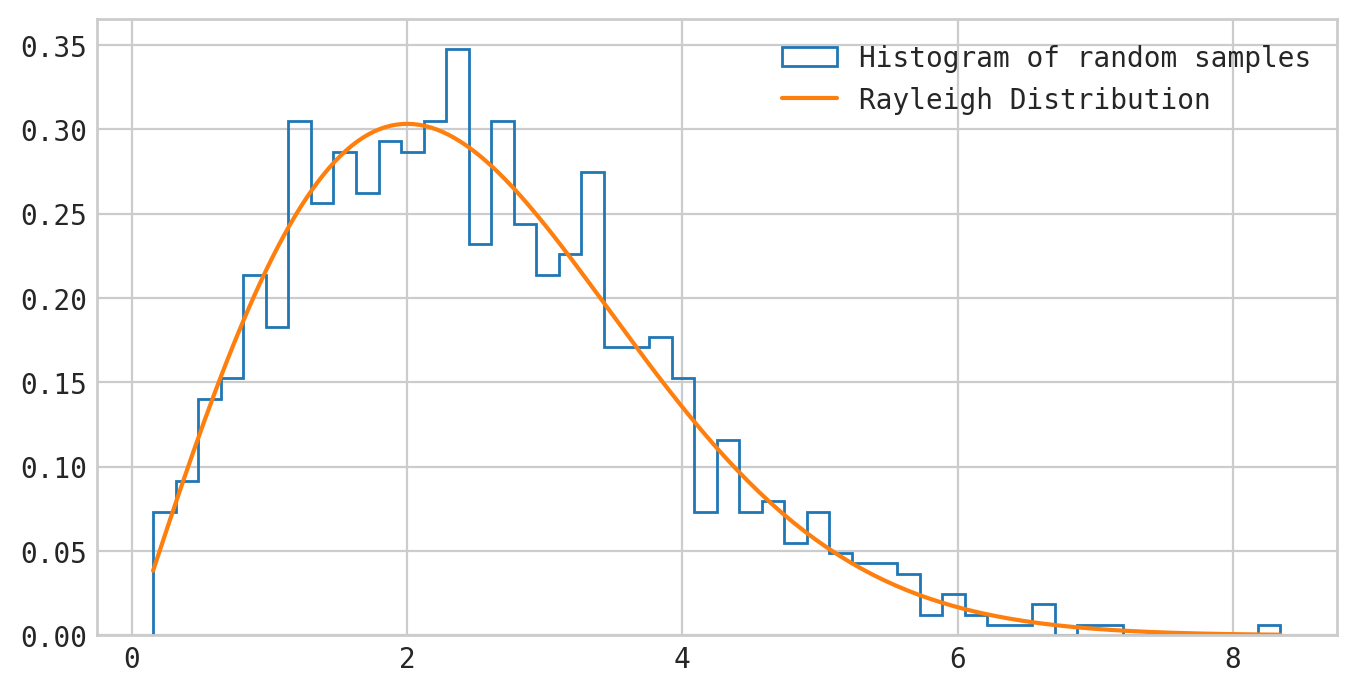

In [86]:
samples = inverse_transform_sample(inv_CDF, 1000)
domain = np.linspace(samples.min(), samples.max(), 200)

plt.hist(samples, bins=50, density=True, label='Histogram of random samples', histtype='step')
plt.plot(domain, PDF(domain), label='Rayleigh Distribution')
plt.legend();

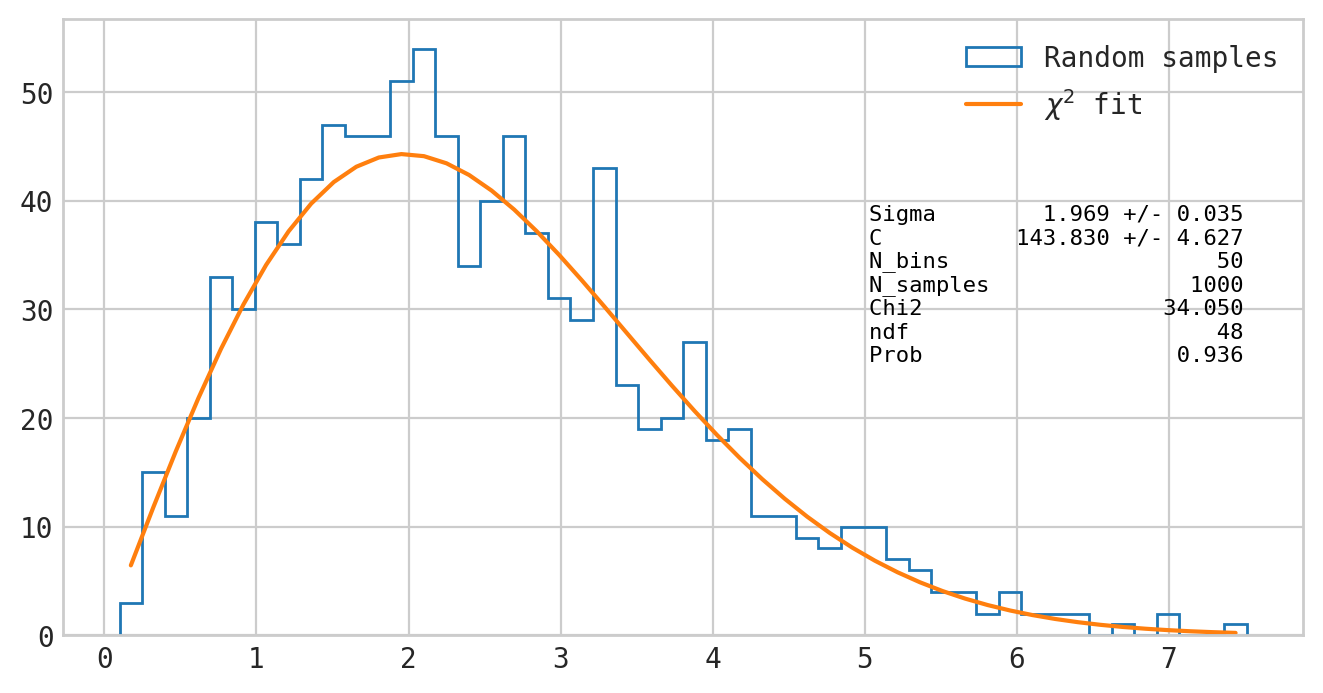

In [85]:
def fit_sigma(x, sigma, C):
    return C*(x/sigma**2) * np.exp(-x**2 / (2*sigma**2))

Nbins = 50

y, x_edges = np.histogram(samples, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_sigma, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, sigma=2, C=200)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables (sigma, C)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(samples, bins=Nbins, histtype='step', label='Random samples')
plt.plot(x, fit_sigma(x, minuit.values['sigma'], minuit.values['C']), label=r'$\chi^2$ fit')
plt.legend()

d = {'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'C': [minuit.values['C'], minuit.errors['C']],
     'N_bins' : Nbins,
     'N_samples' : 1000,
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text, ax, fontsize=8)


In [109]:
def get_sigma_uncertainity(N_samples):

    samples = inverse_transform_sample(inv_CDF, N_samples)

    Nbins = max(10, int(N_samples/20))

    y, x_edges = np.histogram(samples, bins=Nbins)

    x = (x_edges[1:] + x_edges[:-1])/2

    chi2_object = Chi2Regression(fit_sigma, x[y>0], y[y>0], np.sqrt(y)[y>0])
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    minuit = Minuit(chi2_object, sigma=2, C=200)     # External Functions

    # Perform the actual fit:
    minuit.migrad()

    return minuit.errors['sigma']


In [125]:
N_sample_data = np.geomspace(50, 5000, 100)
sigma_err_data = []
for N_samples in tqdm(N_sample_data):
    sigma_err_data.append(get_sigma_uncertainity(int(N_samples)))

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rizfn\AppData\Local\Temp\ipykernel_22612\1498325857.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  newton_x = x - (f_x / df(x))  # attempt newton step
100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


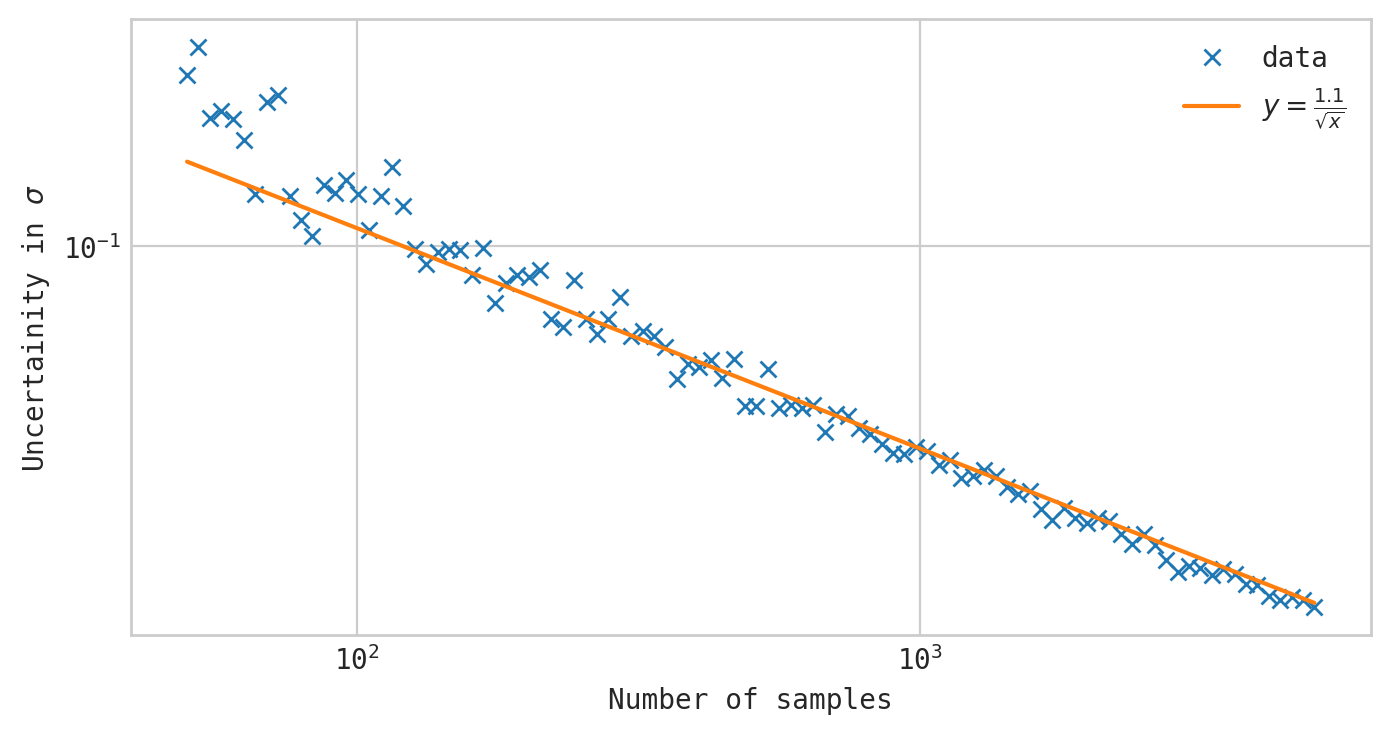

In [140]:
plt.plot(N_sample_data, sigma_err_data, marker='x', linestyle='', label='data')
plt.plot(N_sample_data, 1.1/np.sqrt(N_sample_data), label=r'$y=\frac{1.1}{\sqrt{x}}$')
plt.ylabel(r'Uncertainity in $\sigma$')
plt.xlabel('Number of samples')
plt.yscale('log')
plt.xscale('log')
plt.legend()

# q4

## 4.1

In [490]:
df = pd.read_csv('data_AnorocDisease.csv')
df = df.rename(columns={'  Temp':'Temp','   BloodP':'BloodP', '   Age':'Age', '      Status (0: Healthy; 1: Ill; -1: Unknown)':'Status'})
df

,PatientID,Temp,BloodP,Age,Status
0,1.0,36.3,125.7,56.8,0.0
1,2.0,37.6,121.4,67.7,1.0
2,3.0,38.7,117.6,67.3,1.0
3,4.0,35.8,116.3,60.0,0.0
4,5.0,37.6,142.9,81.9,0.0
...,...,...,...,...,...
995,996.0,37.1,127.6,74.2,-1.0
996,997.0,36.9,123.7,47.1,-1.0
997,998.0,37.3,113.4,39.2,-1.0
998,999.0,37.0,129.3,68.3,-1.0


### prelim plots

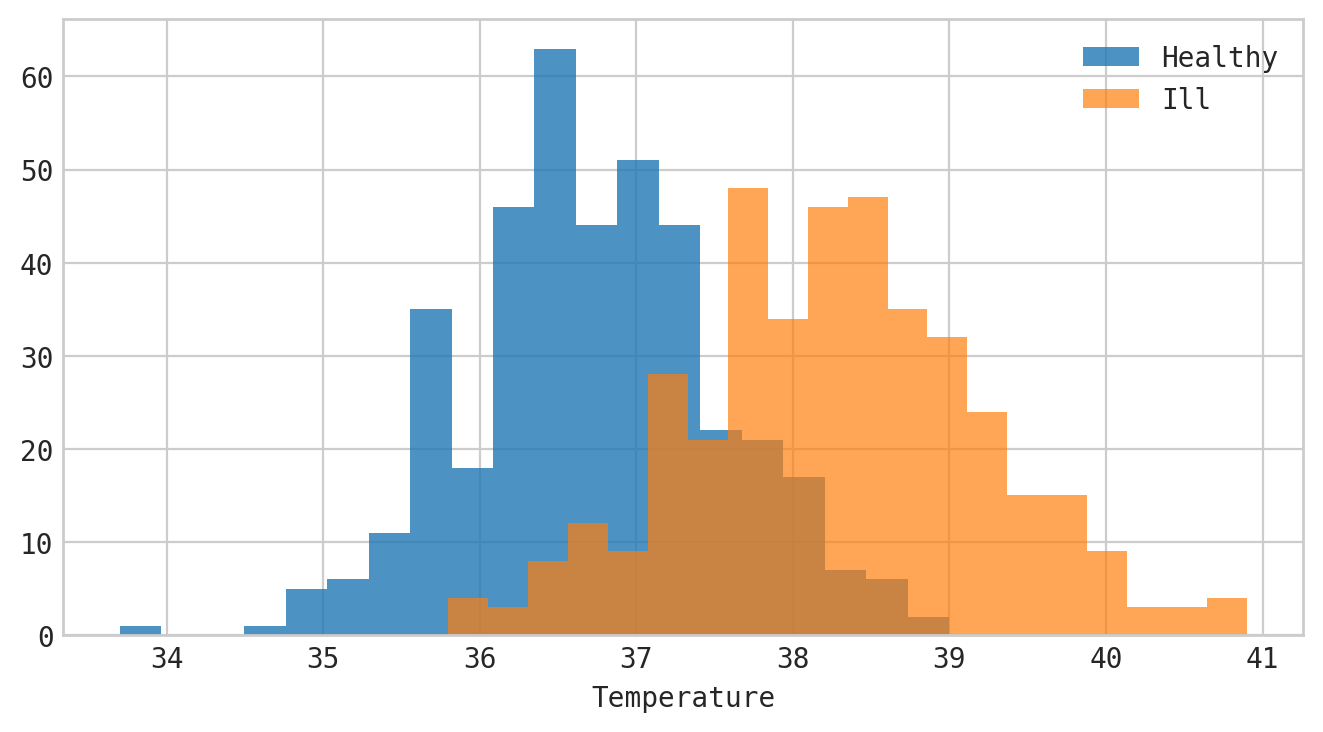

In [162]:
plt.hist(df[df['Status']==0]['Temp'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8)
plt.hist(df[df['Status']==1]['Temp'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
plt.xlabel('Temperature')
plt.legend()

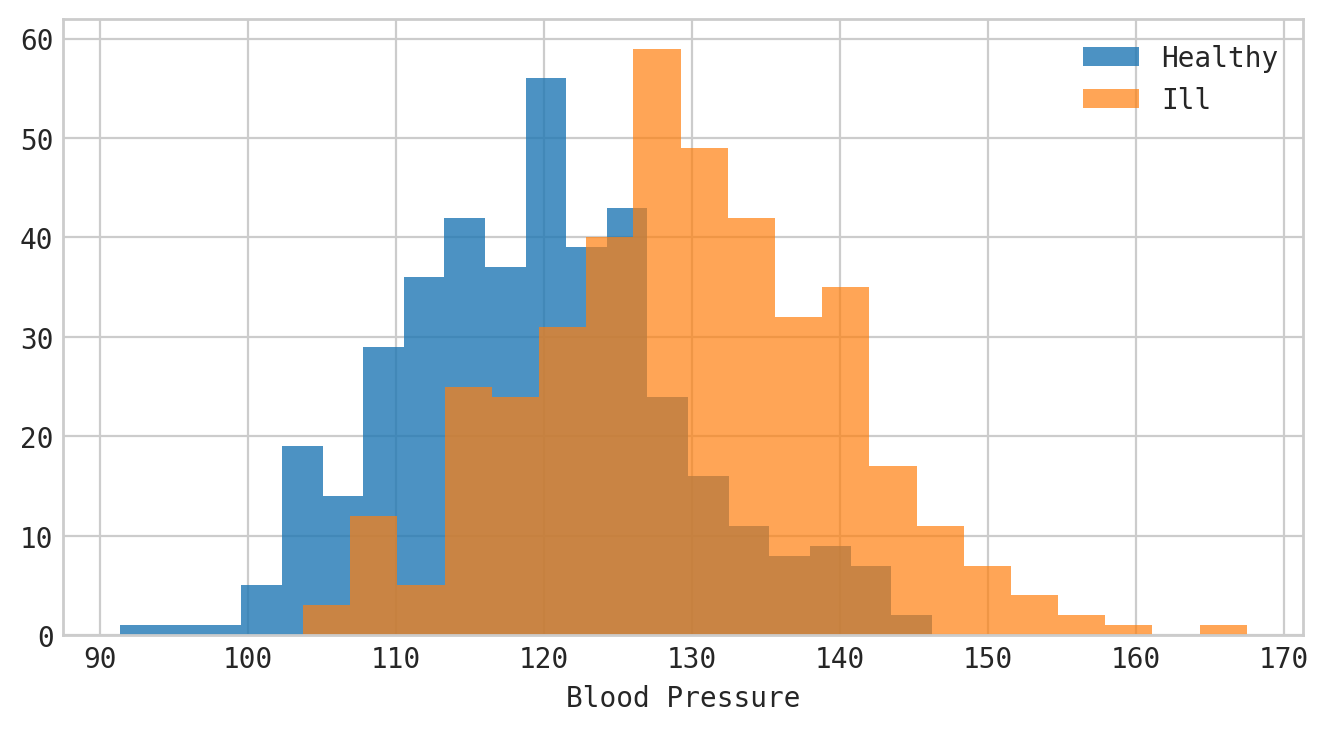

In [163]:
plt.hist(df[df['Status']==0]['BloodP'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8)
plt.hist(df[df['Status']==1]['BloodP'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
plt.xlabel('Blood Pressure')
plt.legend()

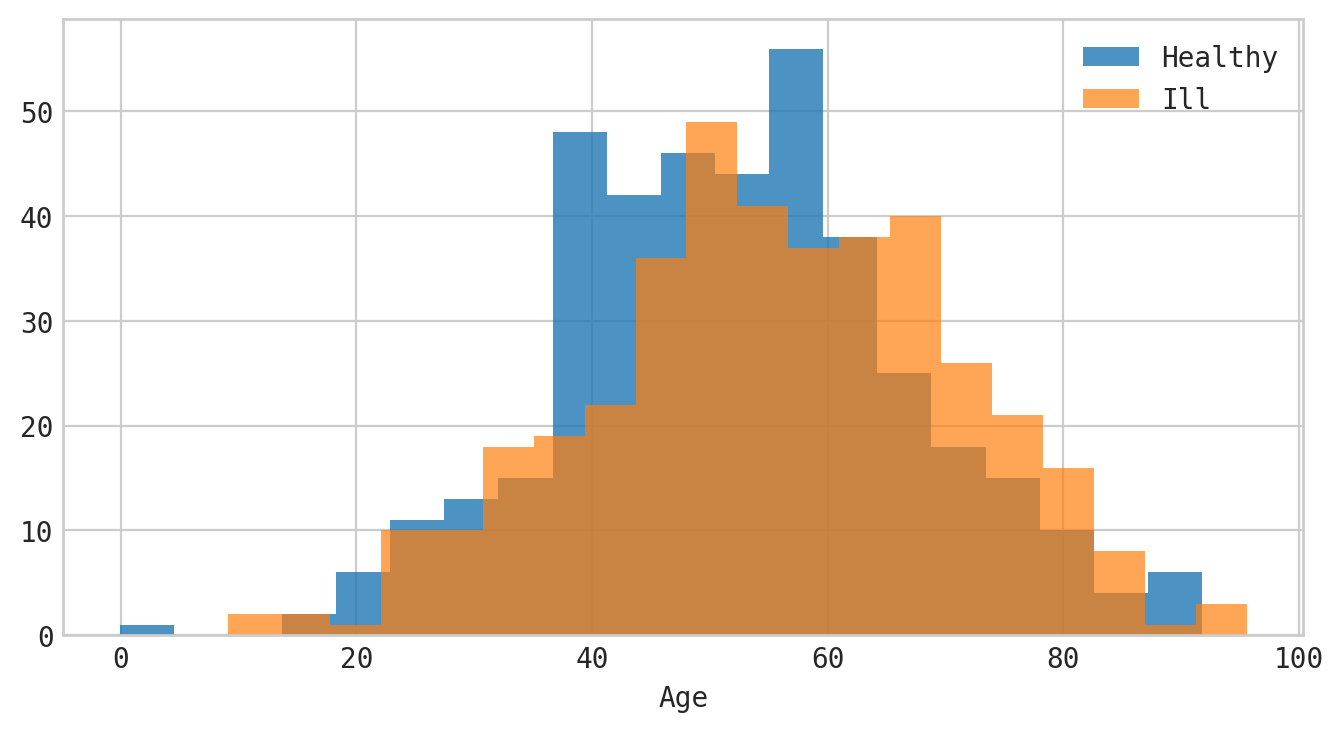

In [166]:
plt.hist(df[df['Status']==0]['Age'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8)
plt.hist(df[df['Status']==1]['Age'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
plt.xlabel('Age')
plt.legend()

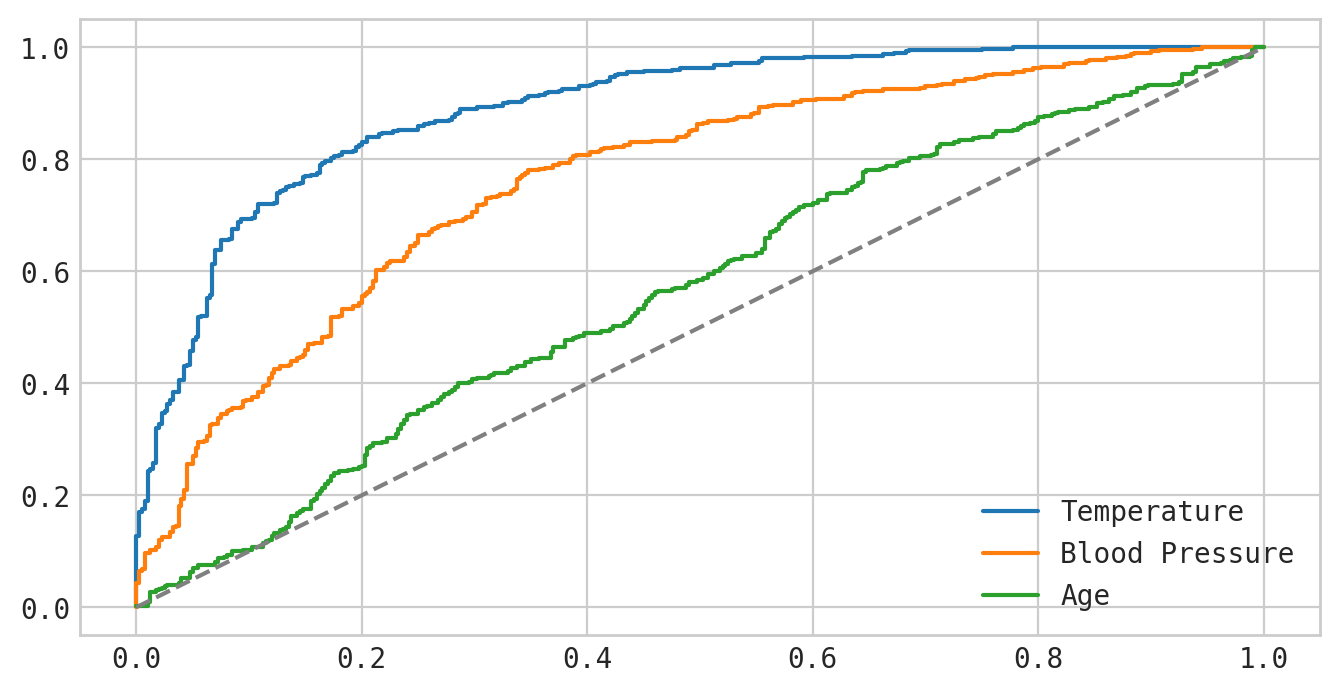

In [188]:
def generate_ROC_data(statistic):
    sorted_df = df.sort_values(by=statistic)
    healthy = sorted_df['Status'] == 0
    ill = sorted_df['Status'] == 1
    cdf1 = ill.cumsum()
    cdf1 /= np.max(cdf1)
    cdf2 = healthy.cumsum()
    cdf2 /= np.max(cdf2)
    return cdf1, cdf2

x, y = generate_ROC_data('Temp')
plt.plot(x, y, label='Temperature')
x, y = generate_ROC_data('BloodP')
plt.plot(x, y, label='Blood Pressure')
x, y = generate_ROC_data('Age')
plt.plot(x, y, label='Age')
plt.plot([0,1], [0,1], linestyle='--', c='grey')
plt.legend()

### actual

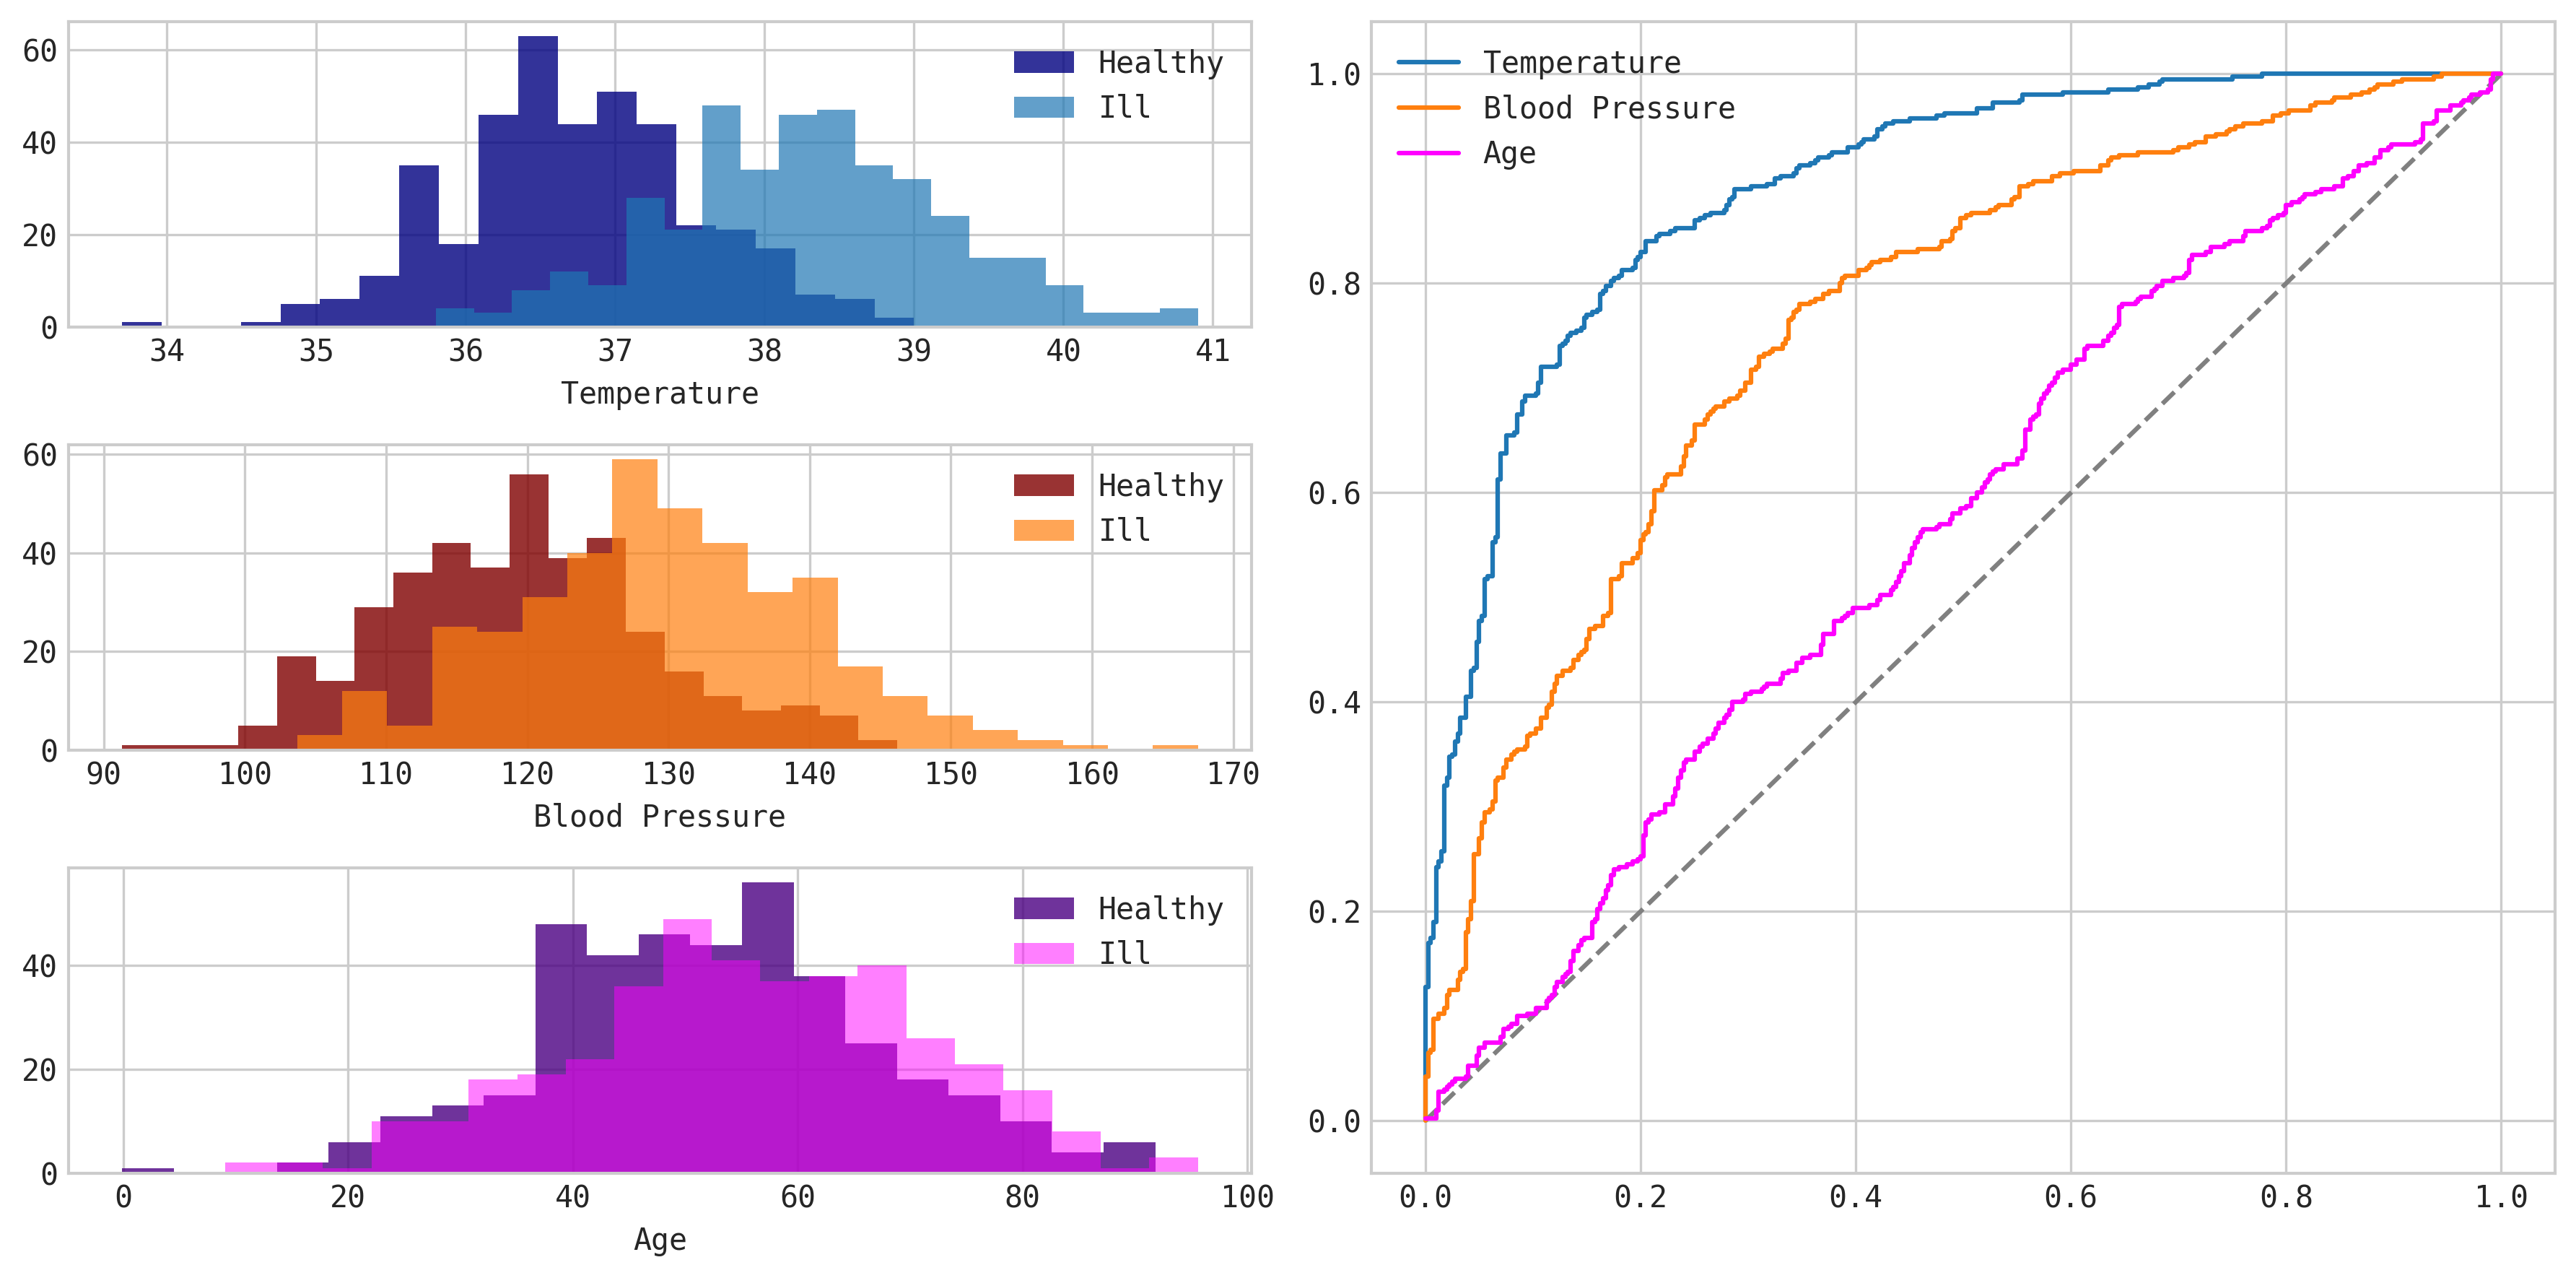

In [491]:
fig = plt.figure(figsize=[12, 6], tight_layout=True, dpi=300)

gs = gridspec.GridSpec(3, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df[df['Status']==0]['Temp'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8, color='navy')
ax1.hist(df[df['Status']==1]['Temp'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
ax1.set_xlabel('Temperature')
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(df[df['Status']==0]['BloodP'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8, color='maroon')
ax2.hist(df[df['Status']==1]['BloodP'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7, color='#ff7f0e')
ax2.set_xlabel('Blood Pressure')
ax2.legend()

ax3 = fig.add_subplot(gs[2, 0])
ax3.hist(df[df['Status']==0]['Age'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8, color='indigo')
ax3.hist(df[df['Status']==1]['Age'], histtype='stepfilled', label='Ill', bins=20, alpha=0.5, color='magenta')
ax3.set_xlabel('Age')
ax3.legend()

ax4 = fig.add_subplot(gs[:, 1])
ax4.plot([0,1], [0,1], linestyle='--', c='grey')
x_temp, y_temp = generate_ROC_data('Temp')
x_bloodp, y_bloodp = generate_ROC_data('BloodP')
x_age, y_age = generate_ROC_data('Age')
ax4.plot(x_temp, y_temp, label='Temperature')
ax4.plot(x_bloodp, y_bloodp, label='Blood Pressure')
ax4.plot(x_age, y_age, label='Age', c='magenta')
ax4.legend()


In [492]:
stats.kstest(df[df['Status']==0]['Age'], df[df['Status']==1]['Age'])

KstestResult(statistic=0.1325, pvalue=0.0017621899205092087)

In [493]:
var_names = ['Temp', 'BloodP', 'Age']
nvar = len(var_names)
nspec = 2
mu = np.zeros((nspec, nvar))
std = np.zeros((nspec, nvar))

for ivar in range(nvar):  # COPIED FROM WEEK6 EXCERCISES
    for healthysick in range(nspec):
        data_spec = df[df['Status'] == healthysick]
        data_spec_var = data_spec[var_names[ivar]]
        mu[healthysick, ivar] = data_spec_var.mean()
        std[healthysick, ivar] = data_spec_var.std(ddof=1)

covariances = np.zeros((nvar, nvar, nspec))
for ivar in range(nvar):
    for jvar in range(nvar):        
        for healthysick in range(nspec):
            data_ispec = df[df['Status'] == healthysick]
            data_ispec_ivar = data_ispec[var_names[ivar]]
            data_ispec_jvar = data_ispec[var_names[jvar]]                
            covariances[ivar, jvar, healthysick] = np.cov(data_ispec_ivar, data_ispec_jvar, ddof=1)[0, 1]
                                
covmat_healthy = covariances[:, :, 0]
covmat_sick = covariances[:, :, 1]

combined_covmat = covmat_healthy + covmat_sick
inv_covmat = np.linalg.inv(combined_covmat)

wf = np.dot(inv_covmat, (mu[1, :] - mu[0, :]))

wf

array([0.93810394, 0.02806819, 0.01381178])

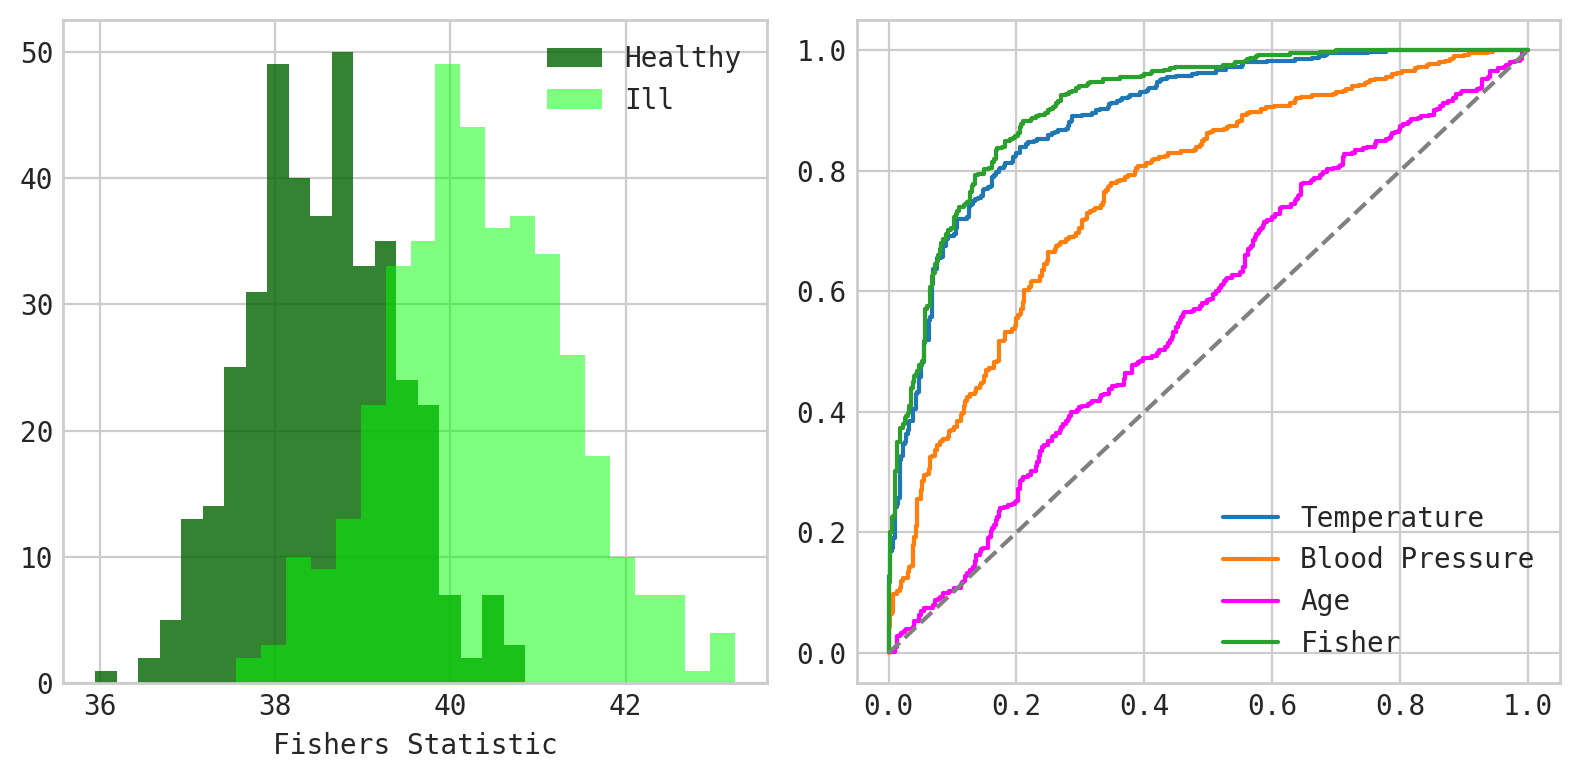

In [494]:
df['Fisher'] = wf[0] * df['Temp'] + wf[1] * df['BloodP'] + wf[2] * df['Age']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 4], tight_layout=True)

ax1.hist(df[df['Status']==0]['Fisher'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8, color='darkgreen')
ax1.hist(df[df['Status']==1]['Fisher'], histtype='stepfilled', label='Ill', bins=20, alpha=0.5, color='lime')
ax1.set_xlabel('Fishers Statistic')
ax1.legend()

x_fisher, y_fisher = generate_ROC_data('Fisher')
ax2.plot(x_temp, y_temp, label='Temperature')
ax2.plot(x_bloodp, y_bloodp, label='Blood Pressure')
ax2.plot(x_age, y_age, label='Age', c='magenta')
ax2.plot(x_fisher, y_fisher, label='Fisher')
ax2.plot([0,1], [0,1], linestyle='--', c='grey')
ax2.legend()


In [297]:
## THINK! it's not that simple, figure out false positives and negatives
# I've actually used FDR and FOR

def calculate_false_negative_positive(fisher_cutoff):
    counts = df[(df['Fisher'] <= fisher_cutoff) & (df['Status'] != -1)]['Status'].value_counts()
    false_negatives = counts[1] / (counts[0] + counts[1])
    counts = df[(df['Fisher'] > fisher_cutoff) & (df['Status'] != -1)]['Status'].value_counts()
    false_positives = counts[0] / (counts[0] + counts[1])
    return false_negatives, false_positives

fisher_space = np.linspace(39, 40, 500)
f_neg_list, f_pos_list = [], []
for cutoff in fisher_space:
    f_neg, f_pos = calculate_false_negative_positive(cutoff)
    f_neg_list.append(f_neg)
    f_pos_list.append(f_pos)

f_neg_list, f_pos_list = np.array(f_neg_list), np.array(f_pos_list)

# min_idx = np.argmin(f_neg_list + f_pos_list)
min_idx = np.argmin(abs(f_neg_list - f_pos_list))
fisher_space[min_idx], f_neg_list[min_idx], f_pos_list[min_idx]


(39.37675350701403, 0.16791979949874686, 0.16957605985037408)

In [299]:
len(df[(df['Fisher']>fisher_space[min_idx]) & (df['Status']==-1)])

59

## 4.2

In [495]:
df = pd.read_csv('data_CountryScores.csv')
df

,Country,GDP,PopSize,Happiness-index,EconomicFreedom-index,PressFreedom-index,Education-index
0,Afghanistan,592.0,18356000.0,2523.0,53.0,40.19,0.414
1,Albania,5837.0,2187000.0,5117.0,65.2,30.59,0.746
2,Algeria,3638.0,27620000.0,4887.0,49.7,47.26,0.672
3,Argentina,9929.0,30799000.0,5929.0,52.7,28.99,0.855
4,Armenia,4595.0,2176000.0,5283.0,71.9,28.83,0.740
...,...,...,...,...,...,...,...
128,Uruguay,16965.0,2530000.0,6431.0,69.3,16.38,0.765
129,Venezuela,1627.0,18359000.0,4892.0,24.7,47.60,0.700
130,Vietnam,3743.0,68565000.0,5411.0,61.7,78.46,0.630
131,Zambia,1115.0,8331000.0,4073.0,50.4,38.21,0.557


In [496]:
print(f"{df['GDP'].mean() = }")
print(f"{df['GDP'].median() = }")
print(f"{df['GDP'].quantile(0.25) = }")
print(f"{df['GDP'].quantile(0.75) = }")

df['GDP'].mean() = 17362.045112781954
df['GDP'].median() = 6677.0
df['GDP'].quantile(0.25) = 2047.0
df['GDP'].quantile(0.75) = 23762.0


In [499]:
logpop = np.log10(df['PopSize'])
stats.shapiro(logpop)

ShapiroResult(statistic=0.9871504306793213, pvalue=0.2499414086341858)

In [500]:
stats.anderson(logpop)

AndersonResult(statistic=0.5203538631359379, critical_values=array([0.56 , 0.638, 0.765, 0.892, 1.062]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [308]:
stats.pearsonr(df['Happiness-index'], df['Education-index'])

PearsonRResult(statistic=0.7647440306793953, pvalue=8.917365454350595e-27)

In [310]:
stats.spearmanr(df['Happiness-index'], df['Education-index'])

SpearmanrResult(correlation=0.8043593869327467, pvalue=2.0653149674359925e-31)

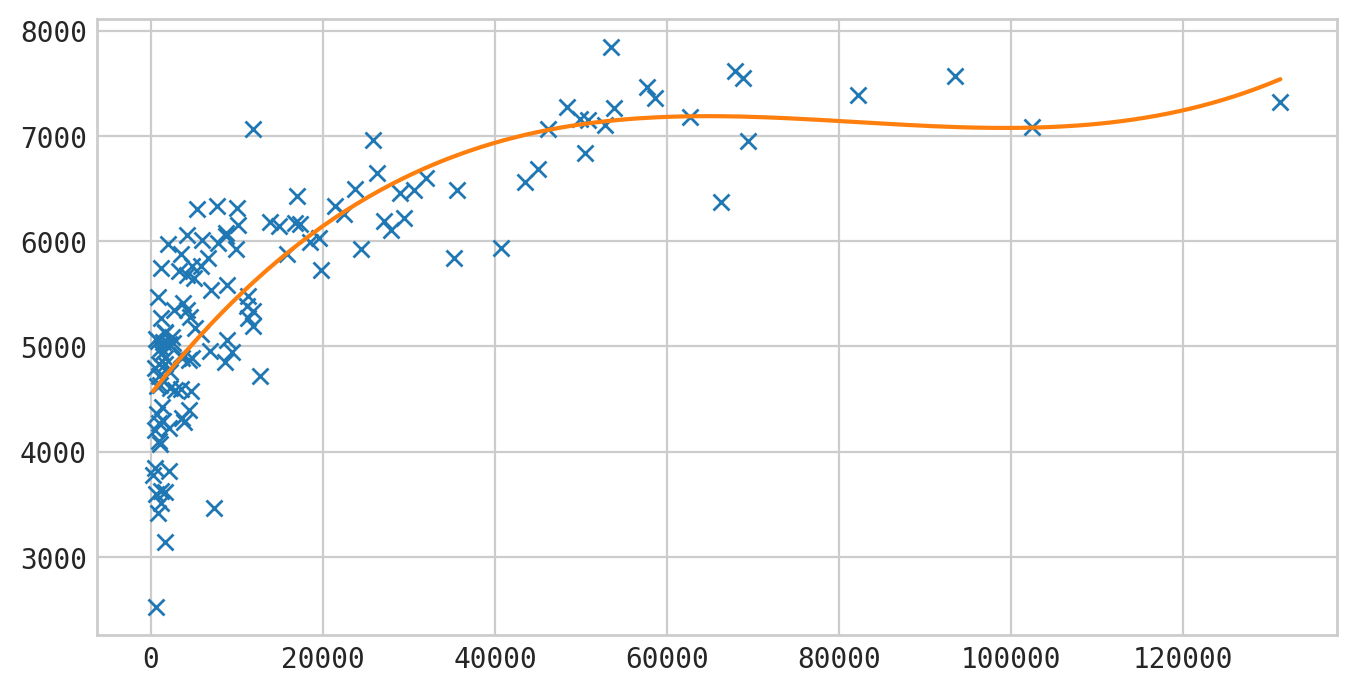

In [369]:
coefs = np.polynomial.Polynomial.fit(df['GDP'], df['Happiness-index'], 3).convert().coef
poly = np.polynomial.Polynomial(coefs)

domain = np.linspace(df['GDP'].min(), df['GDP'].max(), 200)

plt.plot(df['GDP'], df['Happiness-index'], linestyle='', marker='x', label='Data')
plt.plot(domain, poly(domain), label='Polyfit')

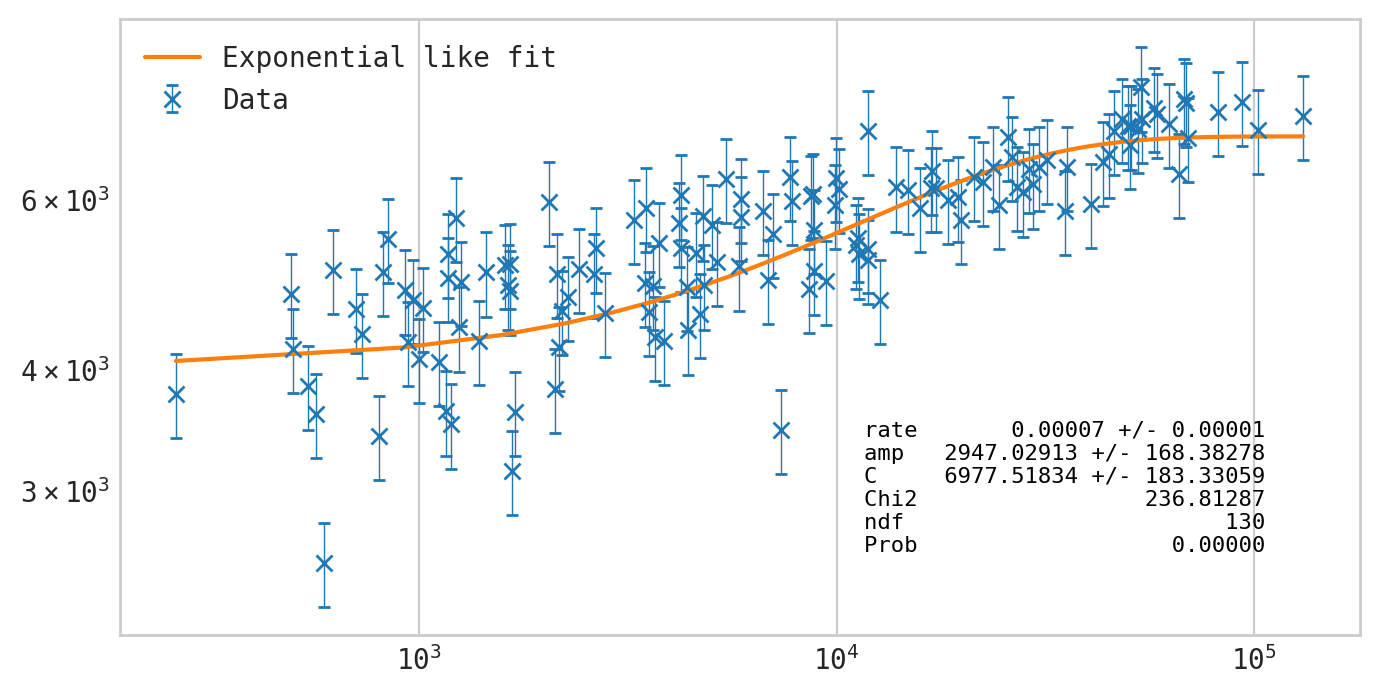

In [378]:
def exponential_CDF_like_fit(x, rate, amp, C):
    return C - amp*np.exp(-rate*x)

chi2_object = Chi2Regression(exponential_CDF_like_fit, df['GDP'], df['Happiness-index'], df['Happiness-index']*0.1)
chi2_object.errordef = 1.0

minuit = Minuit(chi2_object, rate=0.001, amp=3000, C=7000)

minuit.migrad()

Nvar = 3                # Number of variables (rate, C, amp)
Ndof_fit = len(df) - Nvar

Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()

plt.errorbar(df['GDP'], df['Happiness-index'], df['Happiness-index']*0.1, label='Data', capsize=2, elinewidth=0.5, fmt='x ')
plt.plot(domain, exponential_CDF_like_fit(domain, minuit.values['rate'], minuit.values['amp'], minuit.values['C']), label=f'Exponential like fit')
plt.legend()

d = {'rate': [minuit.values['rate'], minuit.errors['rate']],
     'amp': [minuit.values['amp'], minuit.errors['amp']],
     'C': [minuit.values['C'], minuit.errors['C']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.6, 0.35, text, ax, fontsize=8)

plt.yscale('log')
plt.xscale('log')

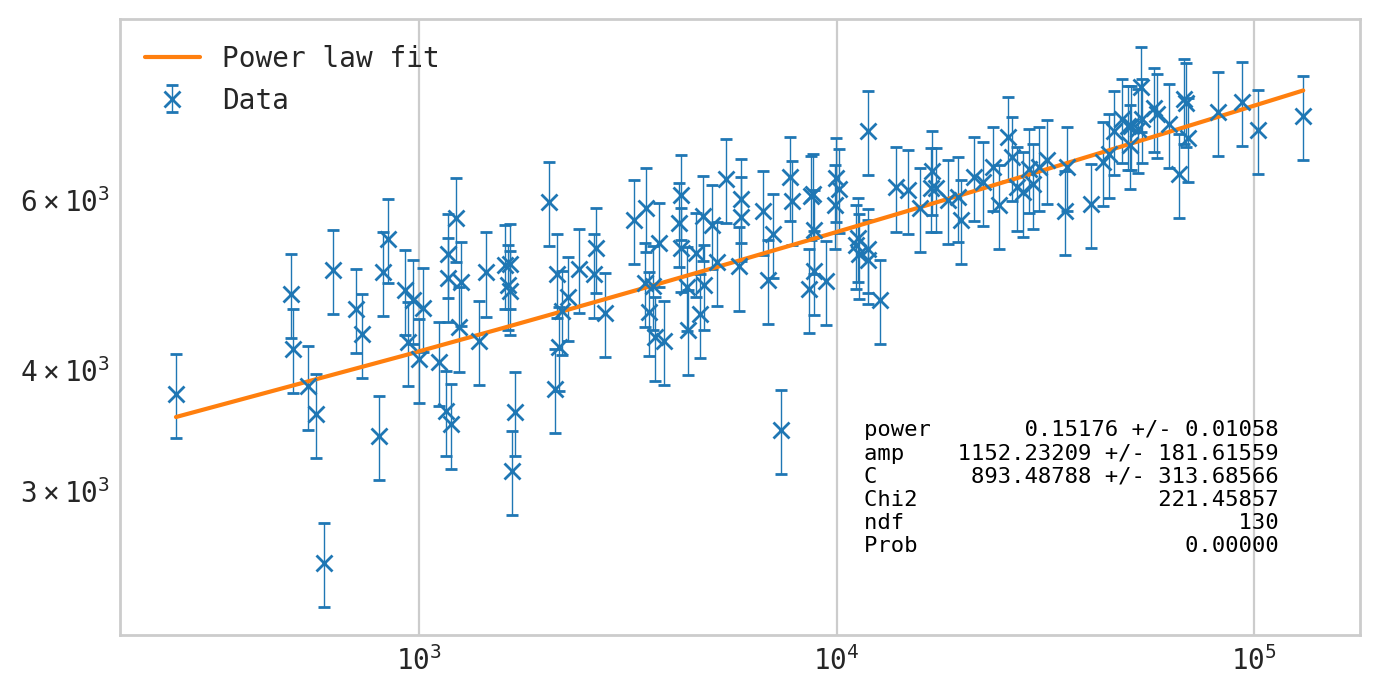

In [377]:
def power_law_fit(x, power, amp, C):
    return C + amp*x**power

chi2_object = Chi2Regression(power_law_fit, df['GDP'], df['Happiness-index'], df['Happiness-index']*0.1)
chi2_object.errordef = 1.0

minuit = Minuit(chi2_object, power=0.1, amp=1000, C=900)

minuit.migrad()

Nvar = 3                # Number of variables (power, C, amp)
Ndof_fit = len(df) - Nvar

Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()

plt.errorbar(df['GDP'], df['Happiness-index'], df['Happiness-index']*0.1, label='Data', capsize=2, elinewidth=0.5, fmt='x ')
plt.plot(domain, power_law_fit(domain, minuit.values['power'], minuit.values['amp'], minuit.values['C']), label=f'Power law fit')
plt.legend()

d = {'power': [minuit.values['power'], minuit.errors['power']],
     'amp': [minuit.values['amp'], minuit.errors['amp']],
     'C': [minuit.values['C'], minuit.errors['C']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.6, 0.35, text, ax, fontsize=8)

plt.yscale('log')
plt.xscale('log')

# q5

In [383]:
df = pd.read_csv('data_GlacierSizes.csv')
df = df.rename(columns={' Area':'Area', ' Volume':'Volume', '    sigArea':'sigArea','  sigVolume':'sigVolume'})
df

,Area,sigArea,Volume,sigVolume
0,2.44922,0.02758,0.10127,0.01091
1,2.48328,0.03630,0.10776,0.00834
2,1.54516,0.02648,0.04989,0.00349
3,2.45672,0.03140,0.06795,0.00104
4,1.45687,0.02270,0.03490,0.00312
...,...,...,...,...
429,2.08141,0.02792,0.10545,0.00791
430,1.76906,0.02897,0.05093,0.00681
431,1.59750,0.02184,0.06665,0.00568
432,1.95797,0.03534,0.06338,0.00384


<ErrorbarContainer object of 3 artists>

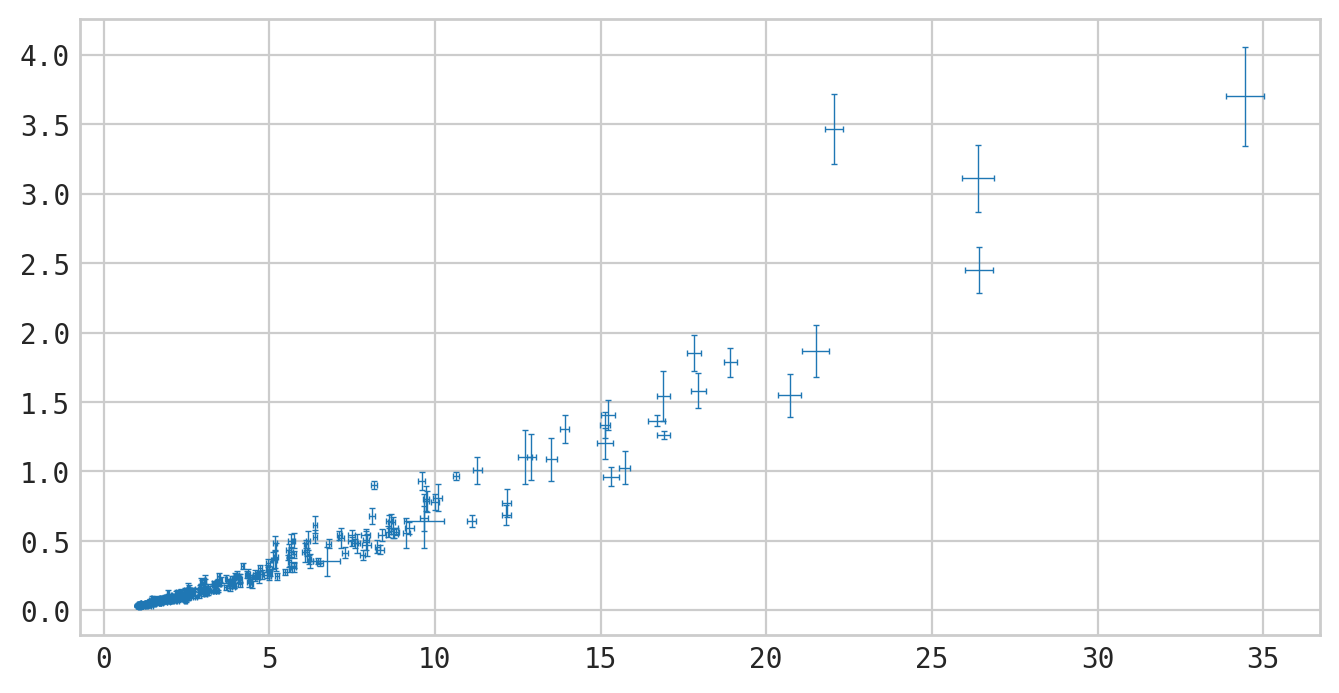

In [395]:
plt.errorbar(df['Area'], df['Volume'], df['sigVolume'], df['sigArea'], label='Data', capsize=1, capthick=0.5, elinewidth=0.5, fmt=' ')
# plt.yscale('log')
# plt.xscale('log')

In [399]:
rel_area_err = df['sigArea'] / df['Area']
rel_vol_err = df['sigVolume'] / df['Volume']
print(f"{rel_area_err.mean() = :.6f}\t+- {rel_area_err.std()/np.sqrt(len(rel_area_err)):.6f}")
print(f"{rel_vol_err.mean() = :.6f}\t+- {rel_vol_err.std()/np.sqrt(len(rel_vol_err)):.6f}")

rel_area_err.mean() = 0.013281	+- 0.000192
rel_vol_err.mean() = 0.100652	+- 0.002386


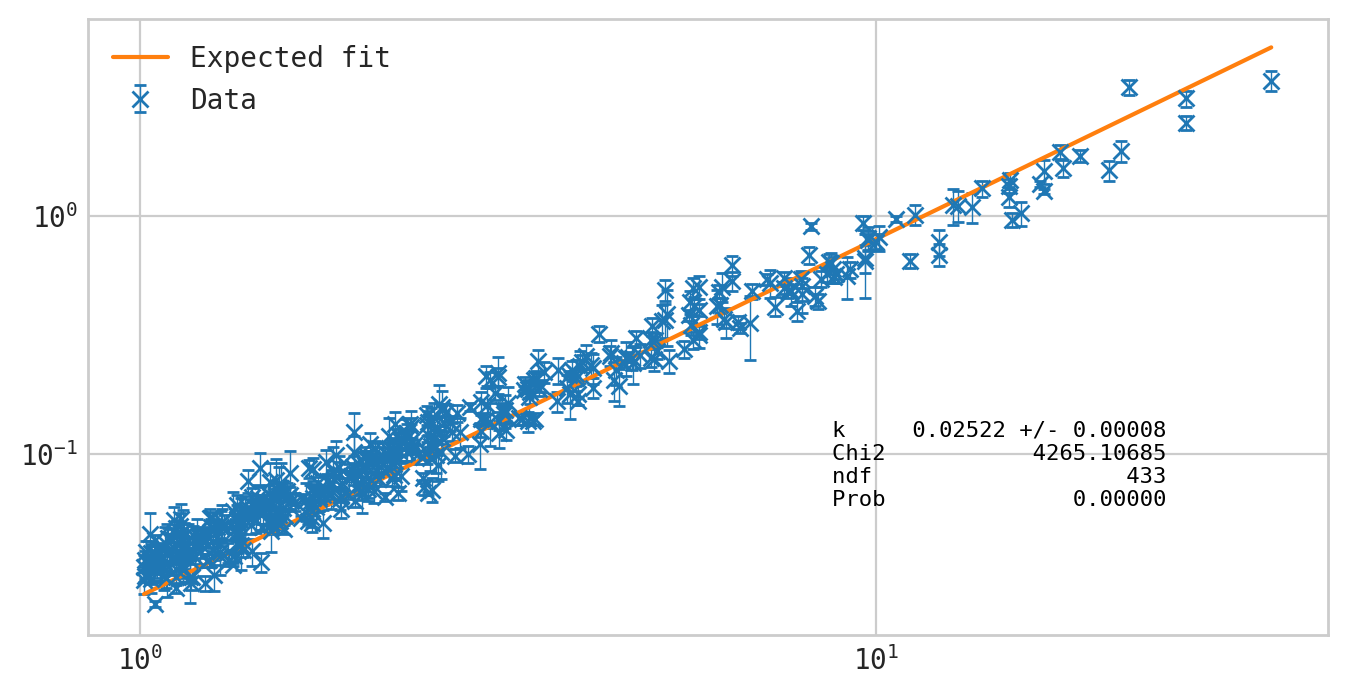

In [403]:
def expected_V_fit(x, k):
    return k*x**(3/2)

domain = np.linspace(df['Area'].min(), df['Area'].max(), 200)

chi2_object = Chi2Regression(expected_V_fit, df['Area'], df['Volume'], df['sigVolume'])
chi2_object.errordef = 1.0

minuit = Minuit(chi2_object, k=1)

minuit.migrad()

Nvar = 1                                        # Number of variables (k)
Ndof_fit = len(df) - Nvar

Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()

plt.errorbar(df['Area'], df['Volume'], df['sigVolume'], label='Data', capsize=2, elinewidth=0.5, fmt='x ')
plt.plot(domain, expected_V_fit(domain, minuit.values['k']), label=f'Expected fit')
plt.legend()

d = {'k': [minuit.values['k'], minuit.errors['k']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.6, 0.35, text, ax, fontsize=8)

plt.yscale('log')
plt.xscale('log')

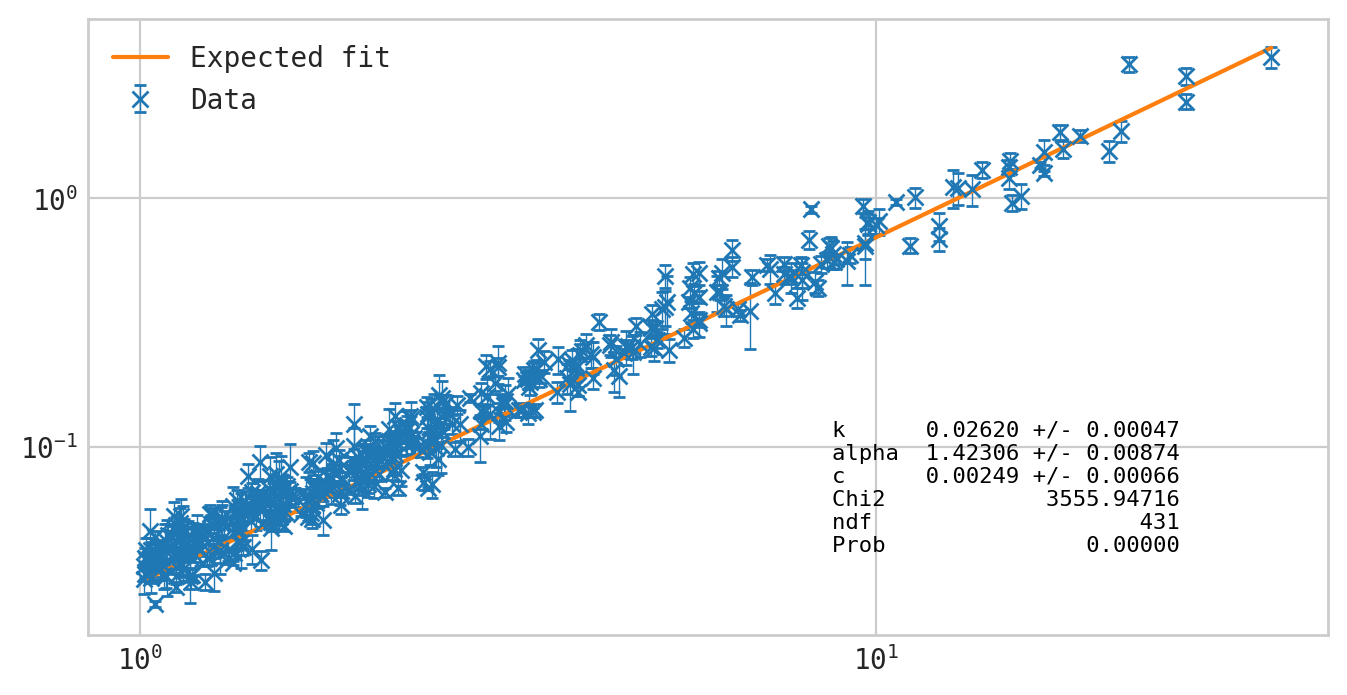

In [406]:
def modified_V_fit(x, k, alpha, c):
    return k*x**(alpha) + c

domain = np.linspace(df['Area'].min(), df['Area'].max(), 200)

chi2_object = Chi2Regression(modified_V_fit, df['Area'], df['Volume'], df['sigVolume'])
chi2_object.errordef = 1.0

minuit = Minuit(chi2_object, k=1, alpha=3/2, c=0.01)

minuit.migrad()

Nvar = 3                                        # Number of variables (k, alpha, c)
Ndof_fit = len(df) - Nvar

Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()

plt.errorbar(df['Area'], df['Volume'], df['sigVolume'], label='Data', capsize=2, elinewidth=0.5, fmt='x ')
plt.plot(domain, modified_V_fit(domain, minuit.values['k'], minuit.values['alpha'], minuit.values['c']), label=f'Expected fit')
plt.legend()

d = {'k': [minuit.values['k'], minuit.errors['k']],
     'alpha': [minuit.values['alpha'], minuit.errors['alpha']],
     'c': [minuit.values['c'], minuit.errors['c']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.6, 0.35, text, ax, fontsize=8)

plt.yscale('log')
plt.xscale('log')

In [407]:
## ripped from a github gist on the beautiful internet
def WaldWolfowitzRuns(L):
  def getRuns(l):
    import itertools
    return len([sum(1 for _ in r) for _, r in itertools.groupby(l)])

  def WW_runs_test(R, n1, n2, n):
      # compute the standard error of R if the null (random) is true
      seR = np.sqrt( ((2*n1*n2) * (2*n1*n2 - n)) / ((n**2)*(n-1)) )

      # compute the expected value of R if the null is true
      muR = ((2*n1*n2)/n) + 1

      # test statistic: R vs muR
      z = (R - muR) / seR

      return z


  # Gather info 
  numRuns = getRuns(L) # Grab streaks in the data

  # Define parameters
  R = numRuns      # number of runs
  n1 = sum(L)      # number of 1's
  n2 = len(L) - n1 # number of 0's
  n = n1 + n2      # should equal len(L)

  # Run the test
  ww_z = WW_runs_test(R, n1, n2, n)

  # test the pvalue
  p_values_one = stats.norm.sf(abs(ww_z))   #one-sided
  p_values_two = stats.norm.sf(abs(ww_z))*2 #twosided

  # Print results
  print('Wald-Wolfowitz Runs Test')
  print('Number of runs: %s' %(R))
  print('Number of 1\'s: %s; Number of 0\'s: %s ' %(n1,n2))
  print('Z value: %s' %(ww_z))
  print('One tailed P value: %s; Two tailed P value: %s ' %(p_values_one, p_values_two))

residuals = df['Volume']-modified_V_fit(df['Area'], minuit.values['k'], minuit.values['alpha'], minuit.values['c'])

WaldWolfowitzRuns(residuals>0)

Wald-Wolfowitz Runs Test
Number of runs: 158
Number of 1's: 323; Number of 0's: 111 
Z value: -1.0385599539402959
One tailed P value: 0.1495047192220742; Two tailed P value: 0.2990094384441484 
